In [1]:
import backtrader as bt
import pandas as pd

import ccxt
import datetime

import matplotlib.pyplot as plt


In [3]:
class SMACrossover(bt.Strategy):
    params = (
        ('fast_sma_period', 10),
        ('slow_sma_period', 30),
        ('printlog', True),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print(f'{dt.isoformat()}, {txt}')


    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.fast_sma = bt.indicators.SimpleMovingAverage(
            self.data.close, period=self.params.fast_sma_period)
        self.slow_sma = bt.indicators.SimpleMovingAverage(
            self.data.close, period=self.params.slow_sma_period)

        self.crossover = bt.indicators.CrossOver(self.fast_sma, self.slow_sma)

        # Indicators for the plotting show
        bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)
        bt.indicators.WeightedMovingAverage(self.datas[0], period=25,
                                            subplot=True)
        bt.indicators.StochasticSlow(self.datas[0])
        bt.indicators.MACDHisto(self.datas[0])
        rsi = bt.indicators.RSI(self.datas[0])
        bt.indicators.SmoothedMovingAverage(rsi, period=10)
        bt.indicators.ATR(self.datas[0], plot=False)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None


    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))


    def next(self):
        # 紀錄一下收盤價
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return
            
        # 檢查是否有部位在市場上, 沒有的話, 才會繼續執行
        if not self.position:
            if self.crossover > 0:
                self.order = self.buy()
                self.log('BUY CREATE, %.2f' % self.data.close[0])
        elif self.crossover < 0:
            self.order = self.sell()
            self.log('SELL CREATE, %.2f' % self.data.close[0])



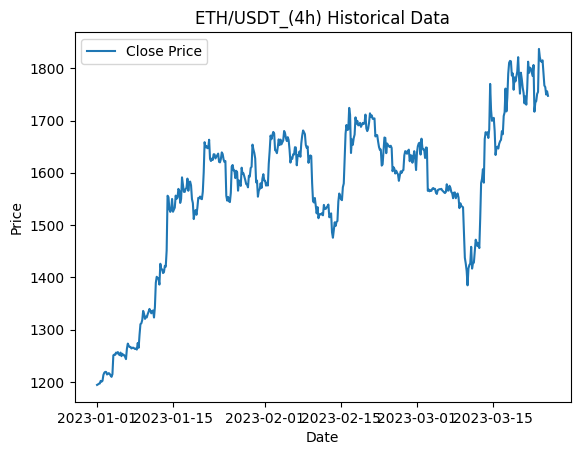

In [4]:
def ccxt_fetch_history_data(symbol = 'BTC/USDT', timeframe = '1d', since_str = '2023-01-01T00:00:00Z'):
    '''
    symbol: 交易市場, 例如 'BTC/USDT' 
    timeframe: Use '1h' for hourly data, '1m' for minute data, etc.
    return df: DataFrame格式的OHLC
    '''
    # Configure CCXT
    exchange = ccxt.binance()
    since = exchange.parse8601(since_str)

    # Fetch historical data using CCXT
    ohlcv_data = exchange.fetch_ohlcv(symbol, timeframe, since)

    # Convert the data to a Pandas DataFrame
    df = pd.DataFrame(ohlcv_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['Date'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('Date', inplace=True)
    df.drop(columns=['timestamp'], inplace=True)

    return df 


_market = 'ETH/USDT'
_timeframe = '4h'

df = ccxt_fetch_history_data(
    symbol = _market, 
    timeframe = _timeframe,
    since_str = '2023-01-01T00:00:00Z'
    )

# Plot the price chart
fig, ax = plt.subplots()
ax.plot(df.index, df['close'], label='Close Price')

# Set plot labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title(f"{_market}_({_timeframe}) Historical Data")

# Show legend and plot
ax.legend()
plt.show()

# Create a Backtrader data feed
data = bt.feeds.PandasData(dataname=df)
 

In [5]:
def run_backtest(strategy, fast_sma_period, slow_sma_period, cash, plot=True):
    cerebro = bt.Cerebro()
    cerebro.addstrategy(strategy, fast_sma_period=fast_sma_period, slow_sma_period=slow_sma_period)
    cerebro.adddata(data)
    cerebro.broker.setcash(cash)
    cerebro.addsizer(bt.sizers.FixedSize, stake=0.1)
    cerebro.broker.setcommission(commission=0.001)
    
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    if plot:
        cerebro.plot(style='candlestick',iplot=False)
        #cerebro.plot()

Starting Portfolio Value: 10000.00
2023-01-06, Close, 1263.01
2023-01-06, Close, 1273.13
2023-01-06, Close, 1269.14
2023-01-07, Close, 1266.54
2023-01-07, Close, 1266.80
2023-01-07, Close, 1263.79
2023-01-07, Close, 1265.07
2023-01-07, Close, 1265.38
2023-01-07, Close, 1264.07
2023-01-08, Close, 1262.84
2023-01-08, Close, 1263.64
2023-01-08, Close, 1261.67
2023-01-08, Close, 1274.25
2023-01-08, Close, 1265.09
2023-01-08, Close, 1290.16
2023-01-09, Close, 1310.37
2023-01-09, Close, 1311.92
2023-01-09, Close, 1318.27
2023-01-09, Close, 1335.68
2023-01-09, Close, 1330.12
2023-01-09, Close, 1320.39
2023-01-10, Close, 1324.71
2023-01-10, Close, 1323.23
2023-01-10, Close, 1329.32
2023-01-10, Close, 1333.97
2023-01-10, Close, 1339.48
2023-01-10, Close, 1335.62
2023-01-11, Close, 1331.07
2023-01-11, Close, 1335.52
2023-01-11, Close, 1336.45
2023-01-11, Close, 1323.04
2023-01-11, Close, 1342.92
2023-01-11, Close, 1389.39
2023-01-12, Close, 1400.99
2023-01-12, Close, 1398.45
2023-01-12, Close, 1

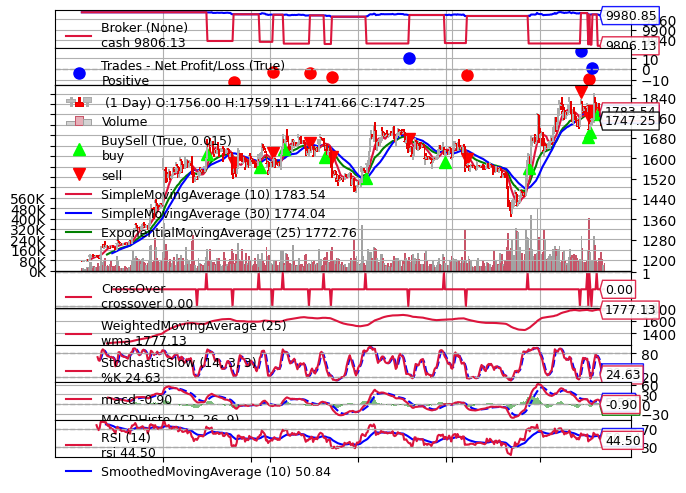

In [7]:
%matplotlib inline

fast_sma_period = 10
slow_sma_period = 30
initial_cash = 10000

run_backtest(
    SMACrossover,
    fast_sma_period=fast_sma_period,
    slow_sma_period=slow_sma_period,
    cash=initial_cash,
    plot=True
)